# Demo of the density limit database

Created: 9/11/2025

Author: Andrew D. Maris, PhD Candidate, MIT Plasma Science and Fusion Center

In [ ]:
import pandas as pd

## Goal: predicting the density limit 

One obstacle for the leading type of magnetic fusion experiment is the "density limit" [[1]](https://doi.org/10.1088/0741-3335/44/8/201) - a phenomenon where the plasma collapses when its density gets too high. This limit is a significant obstacle to achieving sustained fusion reactions, as higher plasma densities can lead to much higher fusion power output.

In this demo, we will inspect the *Open Density Limit Database*, apply supervised learning to predict the precursor phase of the density limit, and inspect the decision boundary. This dataset contains measurements from the [Alcator C-Mod ](https://en.wikipedia.org/wiki/Alcator_C-Mod) experiment at the [MIT Plasma Science and Fusion Center](https://www.psfc.mit.edu/).

![The interior of the Alcator C-Mod tokamak](figures/alcator_c-mod_interior.jpg "The interior of the Alcator C-Mod tokamak")


## Overview of dataset

First we load the dataset and take a look at its structure. The dataset is stored in a CSV file, where each row corresponds to a time point in a specific discharge (shot). The columns include various plasma parameters, as well as the target variable indicating whether the plasma was stable or unstable to the "density limit" at that time point.

In [ ]:
# Load data from .csv file
df = pd.read_csv('data/DL_DataFrame.csv')

# Show first 10 rows
df.head(10)

,discharge_ID,time,density_limit_phase,density,elongation,minor_radius,plasma_current,toroidal_B_field,triangularity
0,1000606012,0.26,0,1.068483,1.596838,0.215675,0.732045,5.375454,0.366888
1,1000606012,0.27,0,1.072965,1.624681,0.214933,0.742422,5.375454,0.379412
2,1000606012,0.28,0,1.077447,1.652525,0.214190,0.752798,5.375454,0.391936
3,1000606012,0.29,0,1.126277,1.662114,0.212518,0.760581,5.375454,0.392512
4,1000606012,0.30,0,1.175108,1.671703,0.210845,0.768363,5.375454,0.393087
5,1000606012,0.31,0,1.173664,1.671543,0.210507,0.776794,5.375454,0.389808
6,1000606012,0.32,0,1.172220,1.671383,0.210170,0.785225,5.375454,0.386529
7,1000606012,0.33,0,1.210420,1.676126,0.210850,0.794954,5.375454,0.390294
8,1000606012,0.34,0,1.248619,1.680869,0.211529,0.804682,5.375454,0.394060
9,1000606012,0.35,0,1.267353,1.672665,0.212348,0.811827,5.379239,0.394335


### Dataset features
Although the "density limit" instability is a complex phenomenon, we simplify the problem to a binary classification task. Each time point is labeled as either "before" (0) or "during" (1) the precursor phase of the density limit. The goal is to predict this label based on the other plasma parameters.

The dataset includes the following columns:

- `discharge_ID`: Unique identifier for each discharge.
- `time`: Time point within the discharge. Early time points when the experiment is ramping up are excluded.
- `density_limit_phase` **(target variable)**: Label indicating whether the time point is before (0) or during (1) the precursor density limit instability. Although the "density limit" is a complex phenomenon, we simplify the problem to binary labels: "before" (0) or "during" (1) the precursor phase of the density limit.
- `density`: The average density of electrons in the plasma. Units: 10^20 particles m^-3
- `elongation`: How vertically elongated the plasma is. A value of 1 indicates a circular plasma, greater than 1 indicates the plasma is more tall than it is wide.
- `minor_radius`: Minor radius of the plasma (the smaller radius in a toroidal geometry). Units: meters
- `plasma_current`: Current flowing through the plasma. Units: Mega-Amperes (MA)
- `toroidal_B_field`: Magnetic field strength in the toroidal direction. Units: Tesla (T)
- `triangularity`: Shape parameter indicating how triangular the plasma cross-section is.


Below show the distribution of these variables in the dataset.

In [ ]:
df.describe()

,discharge_ID,time,density_limit_phase,density,elongation,minor_radius,plasma_current,toroidal_B_field,triangularity
count,2.643850e+05,264385.000000,264385.000000,264385.000000,264385.000000,264385.000000,264385.000000,264385.000000,264385.000000
mean,1.150659e+09,0.906065,0.013609,1.435224,1.619862,0.219830,0.831359,5.458991,0.418302
std,1.963002e+07,0.337779,0.115861,0.665418,0.082715,0.003241,0.180571,0.850107,0.057365
min,1.000606e+09,0.260000,0.000000,0.111372,1.025280,0.188411,0.201474,2.305572,0.092485
25%,1.150611e+09,0.620000,0.000000,0.993889,1.577916,0.217862,0.739451,5.401999,0.386119
50%,1.150930e+09,0.910000,0.000000,1.298909,1.628589,0.219730,0.806543,5.424785,0.417746
75%,1.160718e+09,1.190000,0.000000,1.709444,1.669357,0.221749,0.931009,5.461647,0.455768
max,1.160930e+09,1.830000,1.000000,5.664832,1.888492,0.234837,1.782823,7.998816,0.671271


## Example: classification of stable vs unstable time points with a LSVM

Here, we will train a simple linear support vector machine (LSVM) to classify time points as stable (0) or unstable (1) based on the other plasma parameters.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


# 2. Select a couple of simple features (for demo)
# Replace 'density' and 'plasma_current' with columns from your dataset
X = df[['density', 'plasma_current']].values
y = df['density_limit_phase'].values   # 0 = stable, 1 = unstable

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 4. Train linear SVM
clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

# 5. Evaluate model
y_score = clf.decision_function(X_test)

We can see how well the LSVM performs on the test set by plotting the ROC curve and computing the area under the curve (AUC). An AUC of 1 indicates perfect classification, while an AUC of 0.5 corresponds to random guessing.

Area Under the Curve (AUC): 0.977


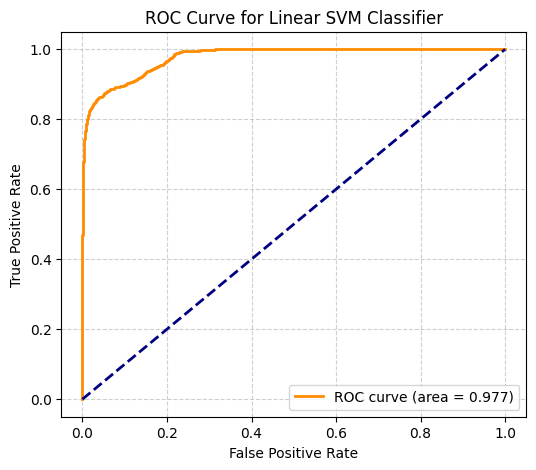

In [ ]:
# 6. Compute FPR, TPR
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
print(f"Area Under the Curve (AUC): {roc_auc:.3f}")

# 7. Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Linear SVM Classifier")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Next, we will print the trained model's decision boundary, and plot the decision boundary along with the test set data.

In [ ]:
# 7. Extract coefficients for boundary equation
w = clf.coef_[0]
b = clf.intercept_[0]
ip_coeff = -w[1] / w[0]
scaled_b = -b / w[0]
print("Decision boundary equation:")
print(f" n = {ip_coeff:.1f} * I_p + {scaled_b:.2f}")

Decision boundary equation:
 n = 4.7 * I_p + -0.01


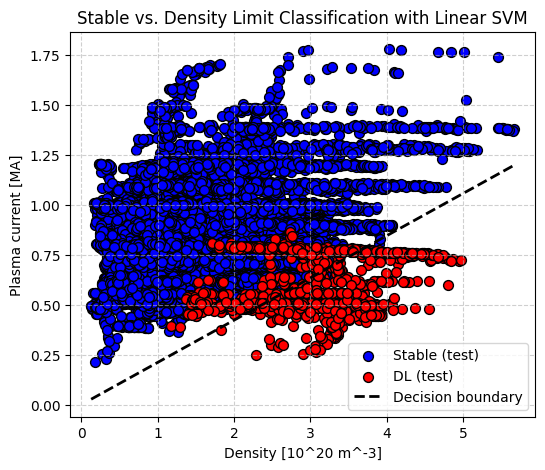

In [ ]:
# 8. Plot boundary equation on test set
# Separate stable (0) and unstable (1) indices
stable_idx = y_test == 0
unstable_idx = y_test == 1

plt.figure(figsize=(6, 5))

# Plot stable 
plt.scatter(X_test[stable_idx, 0], X_test[stable_idx, 1],
            c="blue", edgecolor="k", s=50, label="Stable (test)")
# Plot unstable 
plt.scatter(X_test[unstable_idx, 0], X_test[unstable_idx, 1],
            c="red", edgecolor="k", s=50, label="DL (test)")

plt.xlabel("Density [10^20 m^-3]")
plt.ylabel("Plasma current [MA]")
plt.title("Stable vs. Density Limit Classification with Linear SVM")

# Plot decision boundary
x_vals = np.linspace(X_test[:, 0].min(), X_test[:, 0].max(), 100)
y_vals = -(w[0] * x_vals + b) / w[1]
plt.plot(x_vals, y_vals, "k--", linewidth=2, label="Decision boundary")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

We find a linear decision boundary composed of these two features does a fairly good job of separating the two classes. This makes sense, as the density limit threshold is known to approximately go as $$n_{limit} \propto I_p,$$ where $n$ is the density and $I_p$ is the plasma current.


## Challenge: find a better predictive model for the density limit
Can you find a better predictive model for the density limit instability using this dataset? Try different machine learning algorithms, feature engineering techniques, or hyperparameter tuning to improve the classification performance.

## References

[1] M. Greenwald, "Density limits in toroidal plasmas," Plasma Physics and Controlled Fusion, Aug. 2002, [doi: 10.1088/0741-3335/44/8/201](https://doi.org/10.1088/0741-3335/44/8/201).

## Addendum: visualizing individual discharges

Although the LSVM example above uses only two features for simplicity, the dataset contains multiple features that can be used for more complex models. Additionally, we can visualize how the plasma parameters evolve over time in individual discharges to gain insights into the dynamics leading up to the density limit instability.

Plotting unstable shot: 1000609016


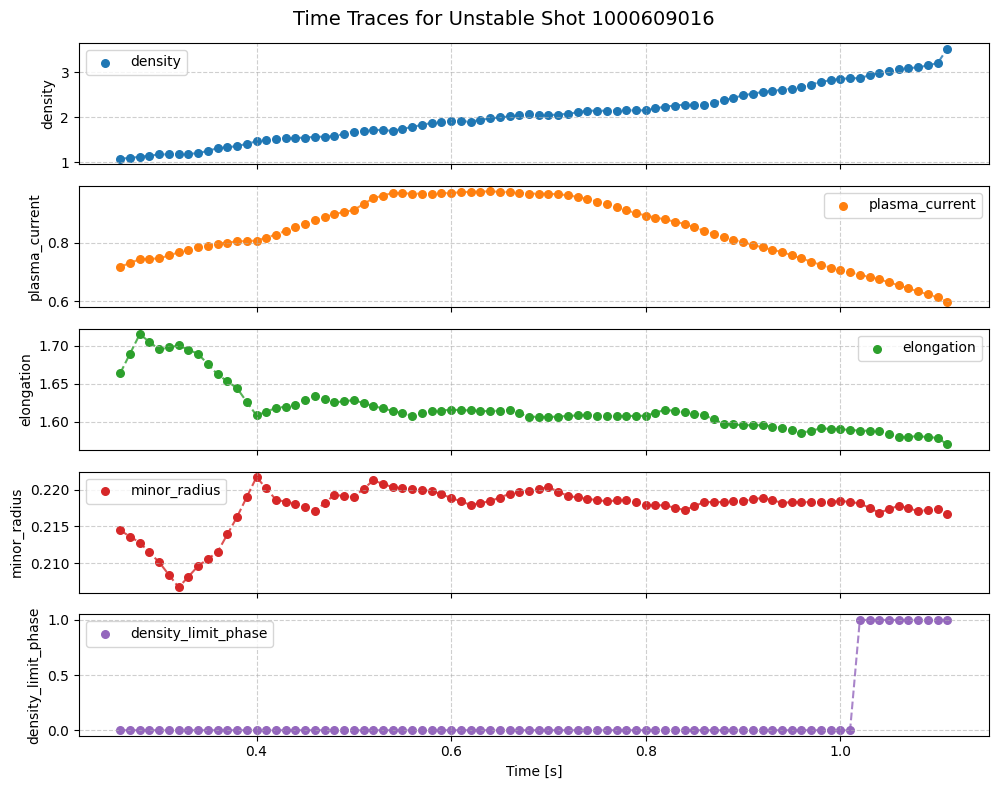

In [ ]:
# 1. Pick a shot
discharge_id = 1000609016
shot_df = df[df['discharge_ID'] == discharge_id]

print(f"Plotting shot: {discharge_id}")

# 2. Define signals to plot (choose time-varying ones)
signals = ['density', 'plasma_current', 'elongation', 'minor_radius', 'density_limit_phase']
time = shot_df['time'].values

# 3. Plot with scatter + dashed lines, one panel per signal
fig, axes = plt.subplots(len(signals), 1, figsize=(10, 8), sharex=True)

colors = plt.cm.tab10.colors  # 10 distinct colors

for i, (ax, sig) in enumerate(zip(axes, signals)):
    ax.plot(time, shot_df[sig], linestyle="--", color=colors[i % 10], alpha=0.8)
    ax.scatter(time, shot_df[sig], color=colors[i % 10], label=sig, s=30)
    ax.set_ylabel(sig)
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.legend(loc="best")

axes[-1].set_xlabel("Time [s]")
fig.suptitle(f"Time Traces for Unstable Shot {discharge_id}", fontsize=14)
plt.tight_layout()
plt.show()